C:\Users\Amin\AppData\Local\Temp\ipykernel_19408\179260965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


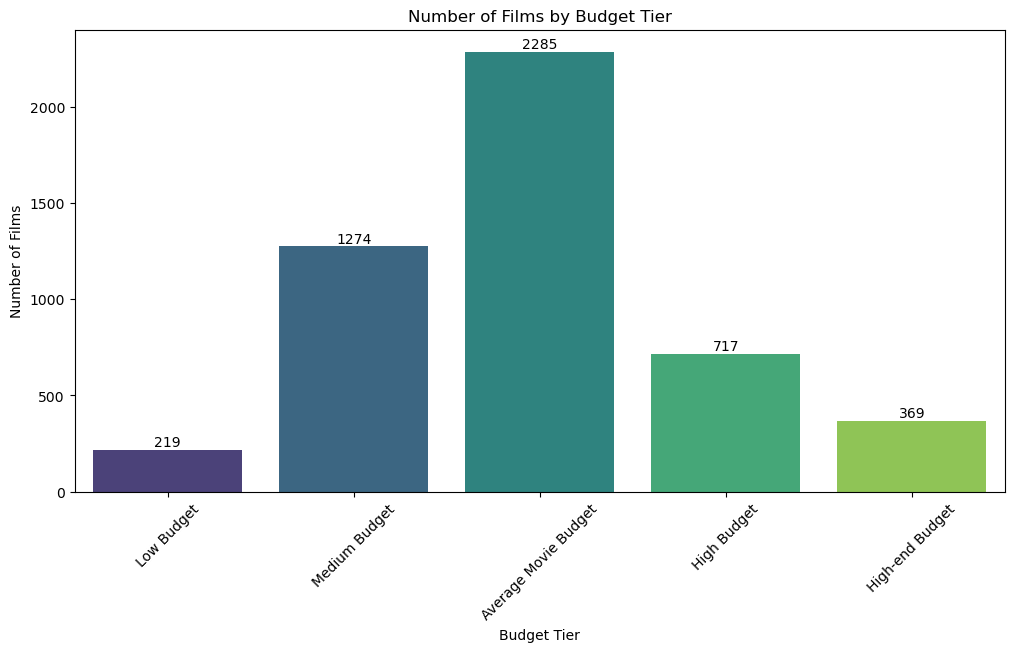

C:\Users\Amin\AppData\Local\Temp\ipykernel_19408\179260965.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


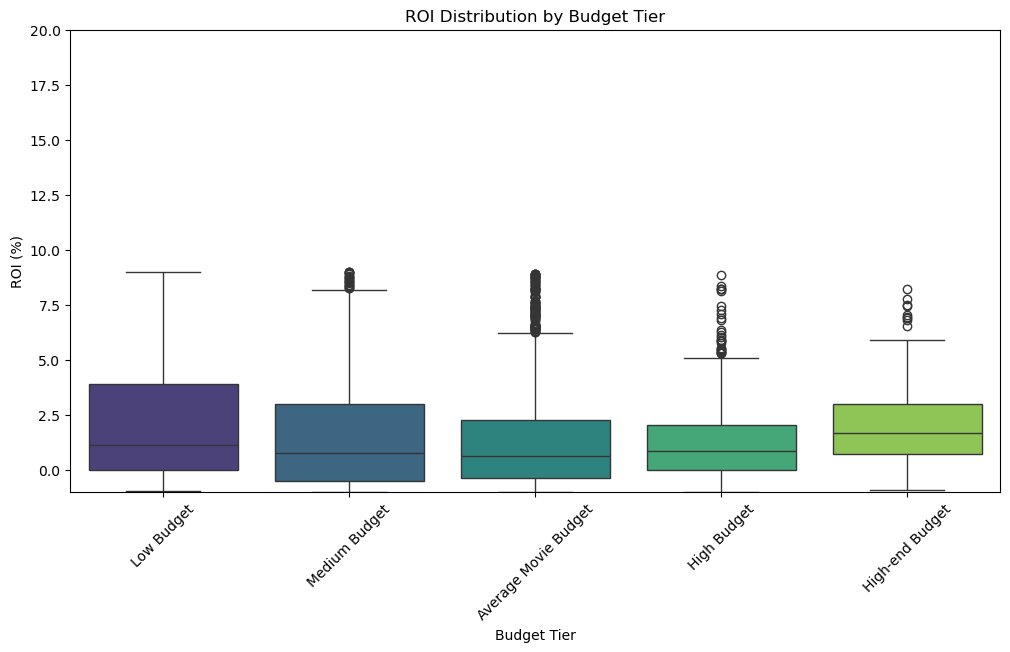

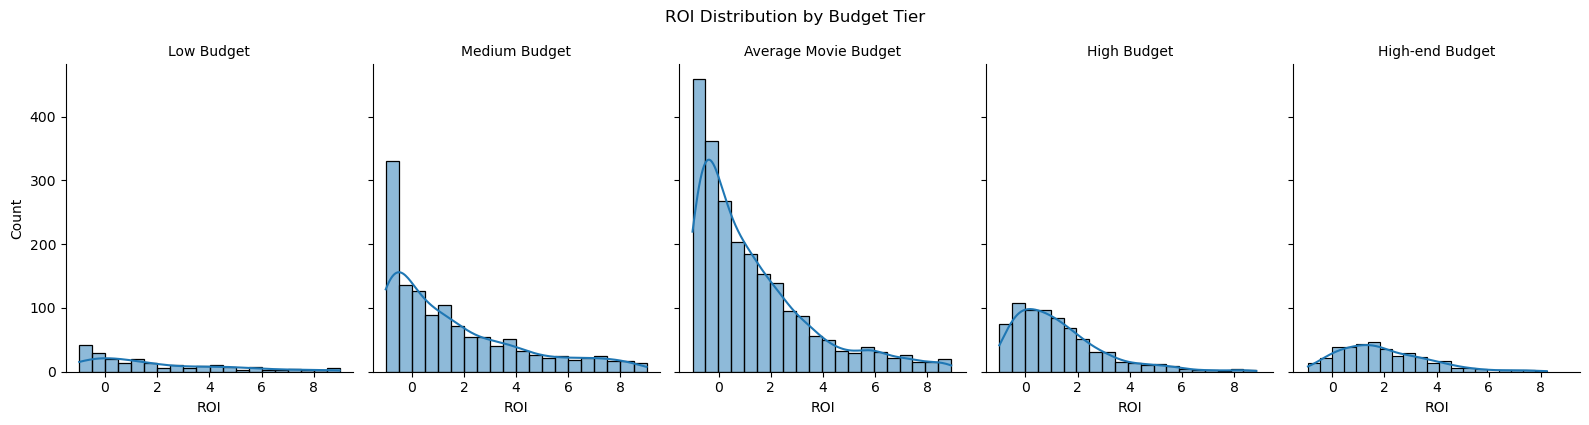

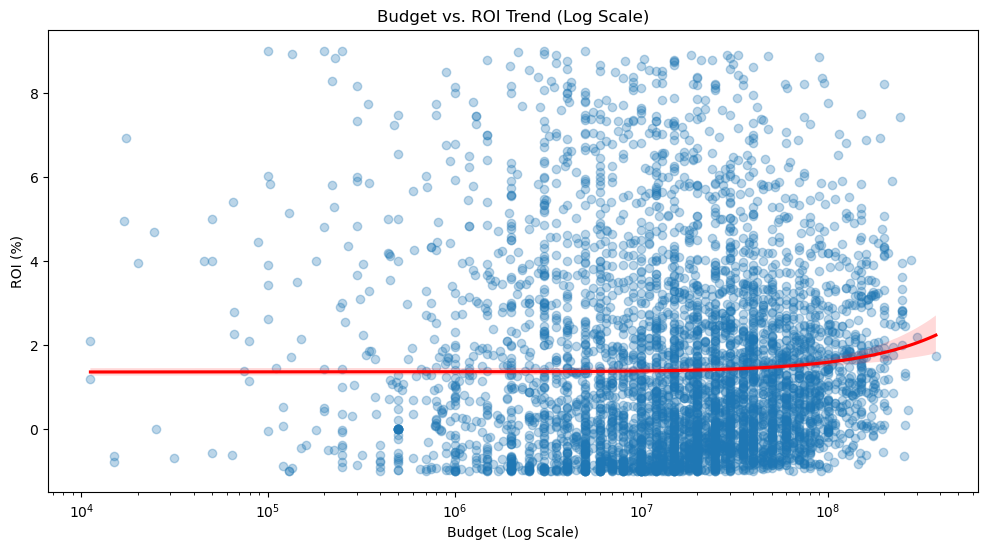

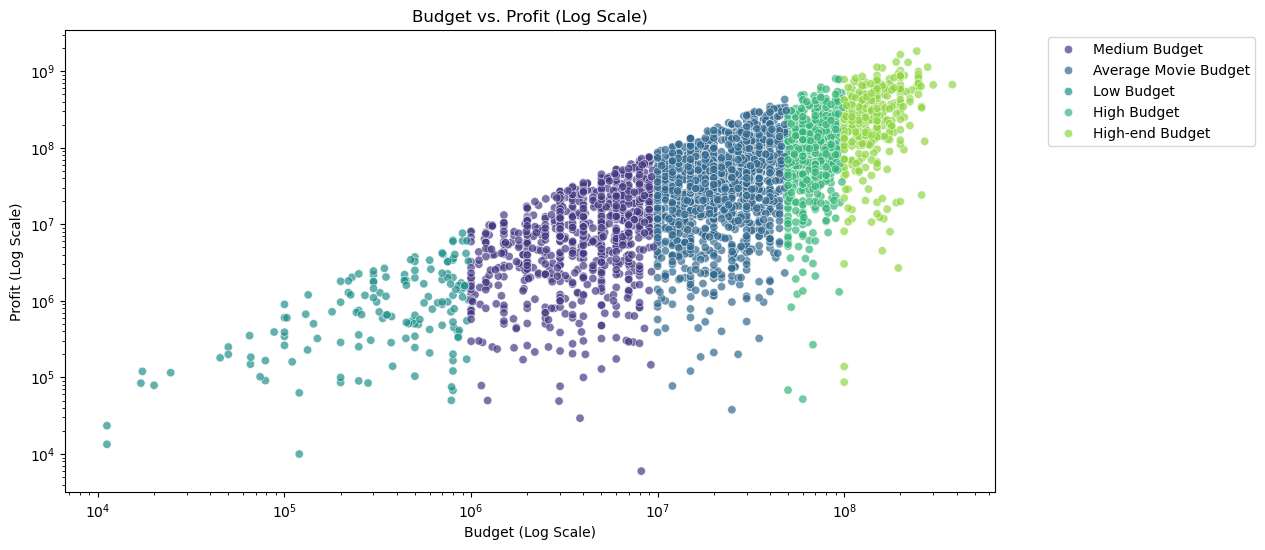

C:\Users\Amin\AppData\Local\Temp\ipykernel_19408\179260965.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


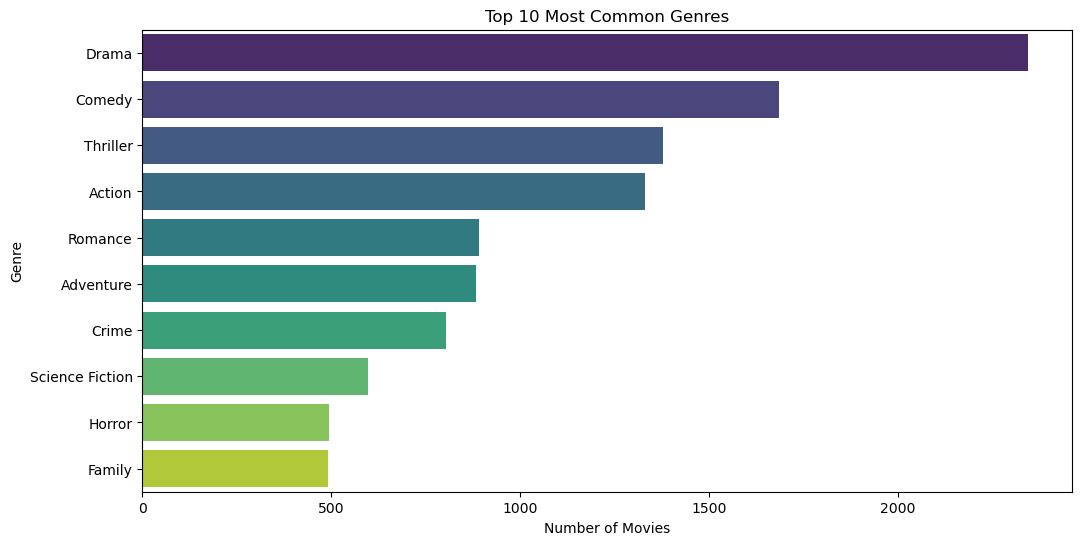

C:\Users\Amin\AppData\Local\Temp\ipykernel_19408\179260965.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


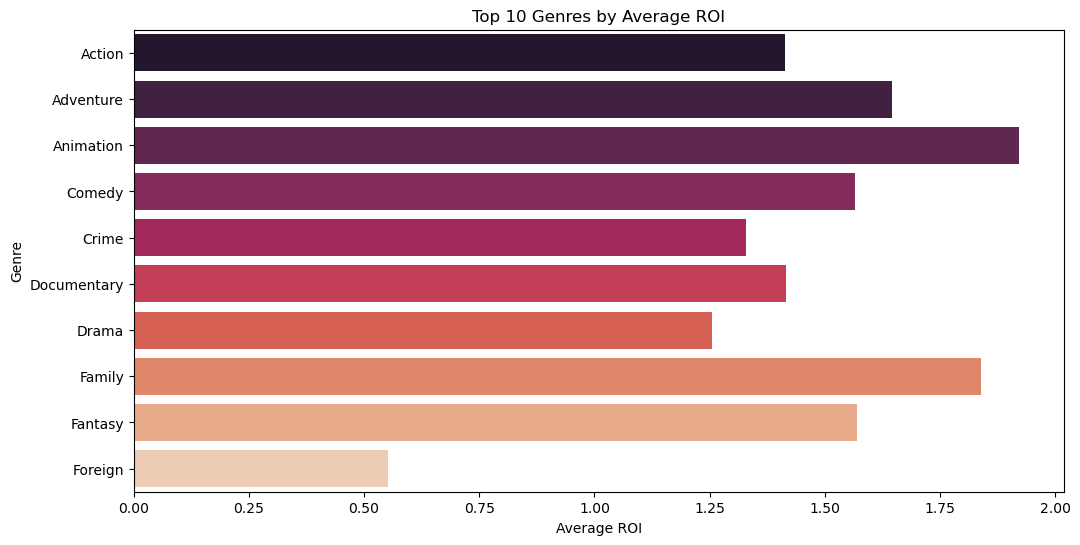

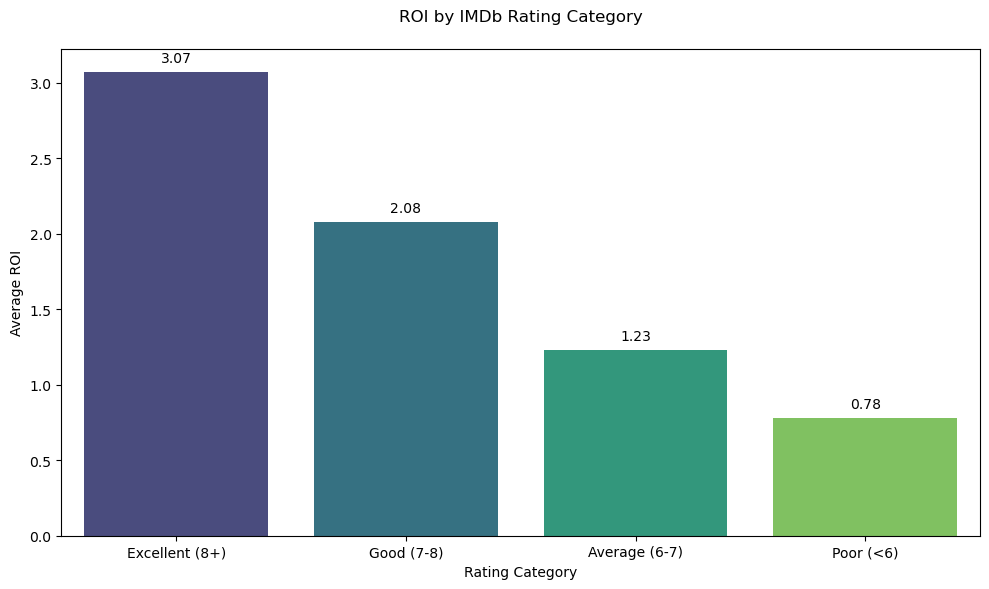

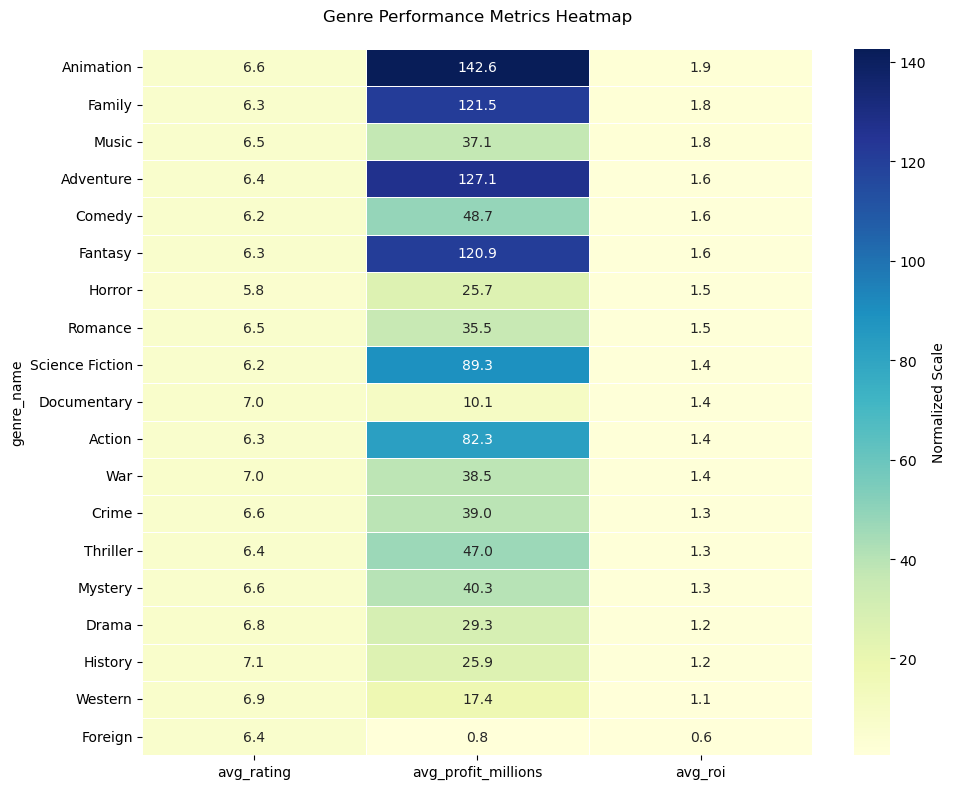

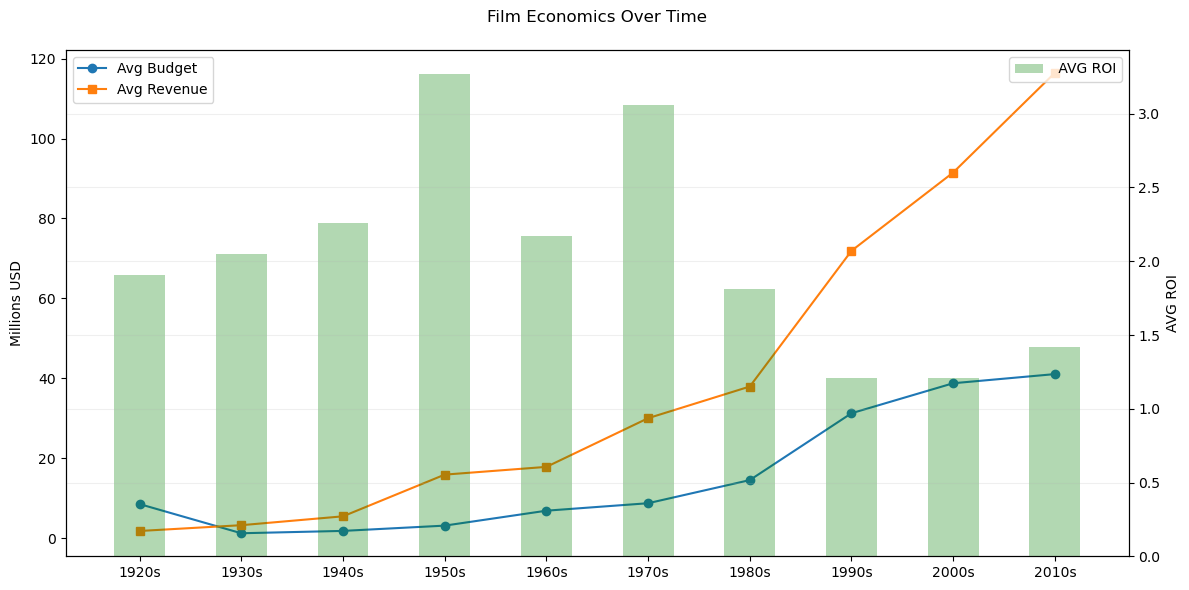

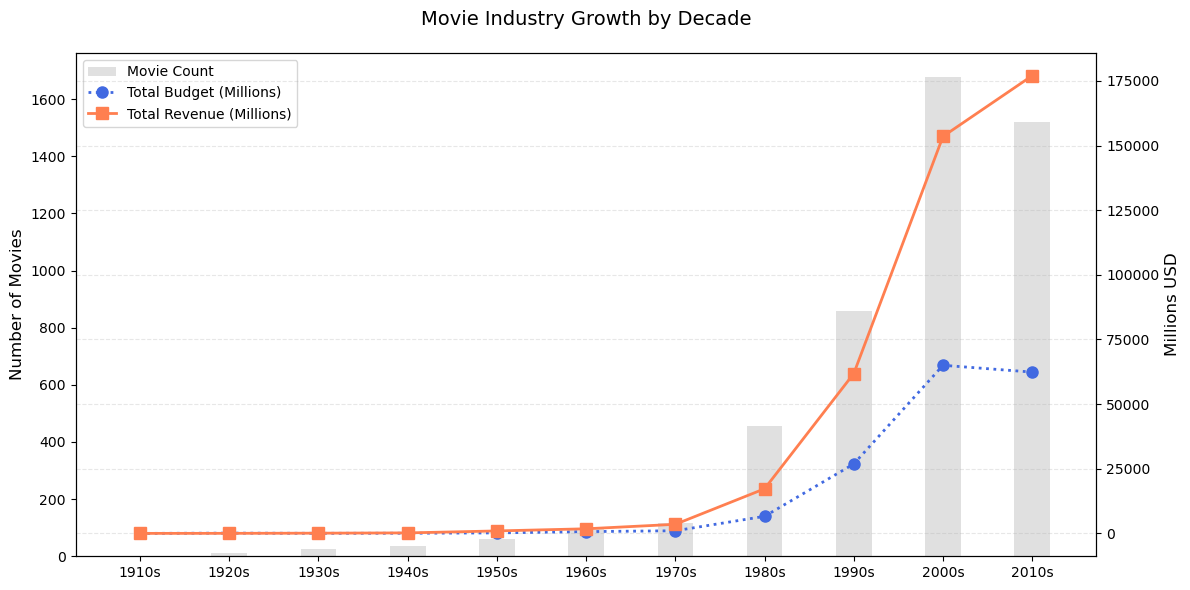

In [ ]:
# %% [markdown]
# # Movie Database Analysis Report
# **Author**: [S.M.Amin Mohammadi,@Guillermo Fiallo-Montero]  
# **Date**: [31.03.2025]

# %% [markdown]
# ## 1. Introduction
# This report analyzes movie industry trends using a dataset of 45,000+ films from Kaggle and 1M+ from IMDb ratings.
# After the cleaning process we created a MovieDB with 4800+ films for our analysis.

# **Business Problem**:
# How can film studios allocate budget wisely to maximixe profits?
# Hypothesis:
# 1. Higher budget size brings in higher profit?
# 2. Movie genres such as Action and Adventure yield best ROI?
# 3. Higher IMDb ratings lead to higher ROI for movies?
# 4. Modern films(2000-2010) require higher budgets but have lower ROI.

# %%
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

# Note that when you use _SQLAlchemy_ and establish the connection, you do not even need to be logged in Sequel Pro or MySQL Workbench.

# Database connection
bd = "movie_db"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/'+bd
engine = create_engine(connection_string)
engine

# %% [markdown]
# ## 2. Budget Efficiency Analysis
# **Question1**: Do higher budgets guarantee higher profits?

# %%
# Query: ROI by Budget Tier
roi_budget=  """
    SELECT 
    fl.imdb_id,
    fl.film_title,
    fc.budget,
    fc.revenue,
    (fc.revenue - fc.budget) / fc.budget AS ROI,
    (fc.revenue - fc.budget) AS profit,
  CASE
            WHEN fc.budget < 1e6 THEN 'Low Budget'				-- ($0-1M)
            WHEN fc.budget < 10e6 THEN 'Medium Budget'			-- ($1M-10M)
            WHEN fc.budget < 50e6 THEN 'Average Movie Budget'	-- ($10M-50M)
            WHEN fc.budget < 100e6 THEN 'High Budget'			-- ($50M-100M)
            ELSE 'High-end Budget'									-- (>$100M)
        END AS budget_tier    
FROM 
    films fl
JOIN 
    finance fc ON fl.imdb_id = fc.imdb_id
WHERE 
    fc.budget > 0 AND fc.revenue > 0;
"""
roi_budget_df = pd.read_sql(roi_budget, engine)

# Get counts and sort by tier order
tier_order = [
    'Low Budget', 
    'Medium Budget', 
    'Average Movie Budget', 
    'High Budget', 
    'High-end Budget'
]

# Count films per tier (include tiers with 0 counts)
tier_counts = (
    roi_budget_df['budget_tier']
    .value_counts()
    .reindex(tier_order, fill_value=0)  # Ensure all tiers appear
    .reset_index()
    .rename(columns={'count': 'film_count'})
)

# Visualization Barplot (Number of Films by Budget Tier)
plt.figure(figsize=(12, 6))
bar = sns.barplot(
    data=tier_counts,
    x='budget_tier',
    y='film_count',
    order=tier_order,
    palette='viridis'
)

# Add count labels on bars
for p in bar.patches:
    bar.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Number of Films by Budget Tier')
plt.xlabel('Budget Tier')
plt.ylabel('Number of Films')
plt.xticks(rotation=45)
plt.show()


# Visualization Box Plot: ROI Distribution by Budget Tier
# Purpose: Compare ROI variability across budget tiers.

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=roi_budget_df,
    x='budget_tier',
    y='ROI',
    order=['Low Budget', 'Medium Budget', 'Average Movie Budget', 'High Budget', 'High-end Budget'],
    palette='viridis'
)
plt.title('ROI Distribution by Budget Tier')
plt.xlabel('Budget Tier')
plt.ylabel('ROI (%)')
plt.ylim(-1, 20)  # Adjust based on your data range
plt.xticks(rotation=45)
plt.show()

#Visualization  Facet Grid: ROI Distribution by Tier 
#Purpose: Detailed distribution analysis.
g = sns.FacetGrid(
    roi_budget_df,
    col='budget_tier',
    col_order=['Low Budget', 'Medium Budget', 'Average Movie Budget', 'High Budget', 'High-end Budget'],
    height=4,
    aspect=0.8
)
g.map(sns.histplot, 'ROI', bins=20, kde=True)
g.set_titles('{col_name}')
g.fig.suptitle('ROI Distribution by Budget Tier', y=1.05)
plt.show()

#Visualization  Regression Plot: Budget vs. ROI
# Purpose: Highlight correlation trends.
plt.figure(figsize=(12, 6))
sns.regplot(
    data=roi_budget_df,
    x='budget',
    y='ROI',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.xscale('log')
plt.title('Budget vs. ROI Trend (Log Scale)')
plt.xlabel('Budget (Log Scale)')
plt.ylabel('ROI (%)')
plt.show()

#Visualization  Log Scale: Budget vs. ROI
plt.figure(figsize=(12, 6))
sns.scatterplot(data=roi_budget_df, 
                x='budget', 
                y='profit', 
                hue='budget_tier',
                palette='viridis', 
                alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs. Profit (Log Scale)')
plt.xlabel('Budget (Log Scale)')
plt.ylabel('Profit (Log Scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# %% [markdown]
# **Key Insight**:  
# Low budget movies are wide-spread with high risk, high reward. High budget movies are a tight cluster usually safer with high ROI and mid budget movies have negative ROI with many flops.

# %% [markdown]
# ## 2. Genre Performance
# **Question**: Which genres give the best ROI?

# %%
# 1a. Number of movies per genre

genre_stats = pd.read_sql("""
    SELECT 
    g.genre_name,
    COUNT(gf.imdb_id) AS movie_count
FROM genre_film gf
JOIN genre g ON gf.genre_id = g.genre_id
GROUP BY g.genre_name
ORDER BY movie_count DESC;
""", engine)

# Visualization
# A. Movies per Genre (Top 10)
plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_stats.head(10),
    x='movie_count',
    y='genre_name',
    palette='viridis'
)
plt.title("Top 10 Most Common Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

# 1b. Movies by number of genres

genre_counts = pd.read_sql("""
    SELECT 
    genre_count,
    COUNT(imdb_id) AS movie_count
FROM (
    SELECT 
        imdb_id,
        COUNT(genre_id) AS genre_count
    FROM genre_film
    GROUP BY imdb_id
) AS sub
GROUP BY genre_count
ORDER BY genre_count;
""", engine)

# 1. Get raw ROI data by genre
roi_data = pd.read_sql("""
    SELECT 
        g.genre_name,
        (fc.revenue - fc.budget)/fc.budget AS roi
    FROM films f
    JOIN finance fc ON f.imdb_id = fc.imdb_id
    JOIN genre_film gf ON f.imdb_id = gf.imdb_id
    JOIN genre g ON gf.genre_id = g.genre_id
    WHERE fc.budget > 0 AND fc.revenue > 0
""", engine)

# 2. Group by genre and compute metrics
genre_metrics = roi_data.groupby('genre_name')['roi'].agg(
    avg_roi='mean',
    min_roi='min',
    max_roi='max',
    std_roi='std',
    median_roi='median'
).reset_index()

#Visualization
# C. ROI by Genre (Top 10)
plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_metrics.head(10),
    x='avg_roi',
    y='genre_name',
    palette='rocket'
)
plt.title("Top 10 Genres by Average ROI")
plt.xlabel("Average ROI")
plt.ylabel("Genre")
plt.show()

# %% [markdown]
# **Key Findings**:  
# - **Animation/Family**: Highest ROI (1.92x-1.84x) despite average ratings  
# - **Documenatary/War**: High ratings at 7.0 but moderate ROI (1.4x)
# - **Foreign**: Lowest ROI among the genres

# %% [markdown]
# ## 4. Ratings vs ROI
# **Question**: Do higher-rated films perform better financially?

# %%
# Query: Rating Categories
rating_profitability = """
    SELECT CASE 
           WHEN r.avg_rating >= 8 THEN 'Excellent (8+)'
           WHEN avg_rating >= 7 THEN 'Good (7-8)'
		   WHEN avg_rating >= 6 THEN 'Average (6-7)'
		   ELSE 'Poor (<6)'
		END AS rating_category,
        COUNT(*) AS movie_count,
        ROUND(AVG(fi.revenue - fi.budget)/1e6, 2) AS avg_profit_millions,
        -- Standard ROI calculation
        ROUND(AVG((fi.revenue - fi.budget)/NULLIF(fi.budget, 0)), 2) AS avg_roi,
    -- Additional metric for context
    ROUND(AVG(fi.revenue/NULLIF(fi.budget, 0)), 2) AS revenue_multiplier
FROM ratings r
JOIN finance fi ON r.imdb_id = fi.imdb_id
WHERE r.avg_rating IS NOT NULL
GROUP BY rating_category
ORDER BY avg_roi DESC;
    """
    
df = pd.read_sql(rating_profitability, engine)

#Visualization bar plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
        data=df, 
        x='rating_category', 
        y='avg_roi',
        hue='rating_category',  
        order=['Excellent (8+)', 'Good (7-8)', 'Average (6-7)', 'Poor (<6)'],
        palette='viridis',
        legend=False  
    )
    
plt.title('ROI by IMDb Rating Category', pad=20)
plt.xlabel('Rating Category')
plt.ylabel('Average ROI')
    
# Add value labels
for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}", 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
    
plt.tight_layout()
plt.show()

# Genre Vs ROI

genre_roi = """
    SELECT 
        g.genre_name,
        COUNT(*) AS movie_count,
        ROUND(AVG(r.avg_rating), 1) AS avg_rating,
        ROUND(AVG(fi.revenue - fi.budget)/1e6, 2) AS avg_profit_millions,
        ROUND(AVG((fi.revenue - fi.budget)/NULLIF(fi.budget, 0)), 2) AS avg_roi
    FROM genre g
    JOIN genre_film gf ON g.genre_id = gf.genre_id
    JOIN ratings r ON gf.imdb_id = r.imdb_id
    JOIN finance fi ON gf.imdb_id = fi.imdb_id
    GROUP BY g.genre_name
    HAVING COUNT(*) >= 10
    ORDER BY avg_roi DESC;
    """
    
df = pd.read_sql(genre_roi, engine)
    
# Prepare matrix for heatmap
metrics = df.set_index('genre_name')[['avg_rating', 'avg_profit_millions', 'avg_roi']]
    
plt.figure(figsize=(10, 8))
sns.heatmap(
        metrics,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=.5,
        cbar_kws={'label': 'Normalized Scale'}
    )
plt.title('Genre Performance Metrics Heatmap', pad=20)
plt.tight_layout()
plt.show()


# %% [markdown]
# **Insight**:  
# Films rated 8+ deliver 3.1x ROI vs Good (7-8) 2.1x vs 1.23x for average-rated films (6-7) and finally 0.8x for poor rated (<6)

# %% [markdown]
# ## 5. Temporal Trends
# **Question**: How have budgets and profitability changed over time? 
# Modern films(2000-2010) require higher budgets but have lower ROI.

# %%
# Query: Decade Analysis
query = """
    SELECT 
        CONCAT(FLOOR(YEAR(f.release_date)/10)*10, 's') AS decade,
        COUNT(*) AS movie_count,
        ROUND(AVG(fi.budget)/1e6, 2) AS avg_budget_millions,
        ROUND(AVG(fi.revenue)/1e6, 2) AS avg_revenue_millions,
        ROUND(AVG((fi.revenue - fi.budget)/NULLIF(fi.budget, 0)), 2) AS avg_roi
    FROM films f
    JOIN finance fi ON f.imdb_id = fi.imdb_id
    WHERE f.release_date IS NOT NULL
    GROUP BY decade
    HAVING COUNT(*) >= 10
    ORDER BY decade;
    """
    
df = pd.read_sql(query, engine)

# Visualization
fig, ax1 = plt.subplots(figsize=(12,6))
    
# Budget/Revenue Lines
ax1.plot(df['decade'], df['avg_budget_millions'], 
             label='Avg Budget', marker='o')
ax1.plot(df['decade'], df['avg_revenue_millions'], 
             label='Avg Revenue', marker='s')
ax1.set_ylabel('Millions USD')
ax1.set_title('Film Economics Over Time', pad=20)
ax1.legend(loc='upper left')
    
# ROI Bars
ax2 = ax1.twinx()
ax2.bar(df['decade'], df['avg_roi'], 
            alpha=0.3, color='green', width=0.5, label=' AVG ROI')
ax2.set_ylabel('AVG ROI')
ax2.legend(loc='upper right')
    
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

# Financial growth of movies 
query = """
    SELECT 
        CONCAT(FLOOR(YEAR(f.release_date)/10)*10, 's') AS decade,
        COUNT(*) AS movie_count,
        ROUND(SUM(fi.budget)/1e6, 2) AS total_budget_millions,
        ROUND(SUM(fi.revenue)/1e6, 2) AS total_revenue_millions
    FROM films f
    JOIN finance fi ON f.imdb_id = fi.imdb_id
    WHERE f.release_date IS NOT NULL
    GROUP BY decade
    ORDER BY decade;
    """
    
df = pd.read_sql(query, engine)
    
# Create figure with primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))
    
# Plot movie counts as bars on primary axis
bars = ax1.bar(df['decade'], df['movie_count'], 
                  color='lightgray', alpha=0.7, width=0.4,
                  label='Movie Count')
ax1.set_ylabel('Number of Movies', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
    
# Create secondary axis for financials
ax2 = ax1.twinx()
    
# Plot budget and revenue lines
budget_line = ax2.plot(df['decade'], df['total_budget_millions'],
                          color='royalblue', marker='o', linestyle=':',
                          linewidth=2, markersize=8,
                          label='Total Budget (Millions)')
    
revenue_line = ax2.plot(df['decade'], df['total_revenue_millions'],
                           color='coral', marker='s', linestyle='-',
                           linewidth=2, markersize=8,
                           label='Total Revenue (Millions)')
ax2.set_ylabel('Millions USD', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
    
# Combine legends
lines = [bars, budget_line[0], revenue_line[0]]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)
    
# Styling
plt.title('Movie Industry Growth by Decade', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# **Key Trend**:  
# - 1950s Peak: 3M→16M (4.1x ROI)
# - Modern Era (2000s-2010s): 41M→116M (1.8x ROI)
#Conclusion:
# 1. Budgets ↑ 32% (2000s: 38.7M→2010s:41M)
# 2. ROI ↓ 56% vs. 1950s (4.1x → 1.8x)
# 3. Profit Margins Shrank:
#   1950s: 1 budget→5 revenue
#   2010s: 1 budget→2.8  revenue
# Critical Nuance:
# Post-2000 ROI is stable (1.4x–1.8x) due to franchises/globalization.

# 📈 Movie production peaked in the 2000s.
# 💰Budgets surged after the 1980s.
# 🎬Blockbusters drove massive revenue growth. (1990s and 2000s)
# 📉2010s: Fewer movies, higher revenues (streaming impact).
# ⚖️Revenues outpaced budgets—better monetization.



# %% [markdown]
# ## 6. Recommendations
# **Strategic Insights**:
# 1. **Budget Smartly**: Target $10-50M or maximum $100M films for optimal ROI and target global markets to combat shrinking margins.
# 2. **Genre Focus**: Prioritize Animation/Family productions
# 3. **Quality Matters**: Aim for 7+ ratings to maximize profits in combination of with the right genre mentioned above.
# 4. **Historical Lesson**: Control budget inflation to maintain profitability

# %% [markdown]
# ## Appendix: SQL Queries Used
# All queries available in:  
# `movie_queries.sql`